In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags, csr_matrix, diags
from scipy.integrate import solve_ivp
from scipy.fftpack import fft2, ifft2

from scipy.linalg import kron

In [17]:
def fft(u0, v0, tspan, n):
    b = 1
    D1 , D2 = 0.1 , 0.1
    nx, ny = n, n
    N = nx * ny
    Lx,Ly = 20,20
    
    ## spectral k values
    kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0,nx/2), np.arange(-nx/2, 0)))
    ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0,ny/2), np.arange(-ny/2, 0)))
    # kx[0] = 1e-6
    # ky[0] = 1e-6
    
    KX, KY = np.meshgrid(kx,ky)
    K = KX**2 + KY**2
    
    ut2 = np.hstack([np.real(fft2(u0)).reshape(N),np.imag(fft2(u0)).reshape(N)])
    vt2 = np.hstack([np.real(fft2(v0)).reshape(N),np.imag(fft2(v0)).reshape(N)])

    # print("Shape of ut2:", ut2.shape)  # Should be (16384,)
    # print("Shape of vt2:", vt2.shape)  # Should be (16384,)
    
    uv_t2 = np.hstack([ut2,vt2])
    
    # print("Shape of uv_t2:", uv_t2.shape) 
   
   
    
    def fft_rhs(t, uvt2 , K, nx,ny , N):
        
        Ut2 = uvt2[:N] + 1j * uvt2[N:2*N]  
        Vt2 = uvt2[2*N:3*N] + 1j * uvt2[3*N:]
        
        Vt = Vt2.reshape((nx,ny))
        Ut = Ut2.reshape((nx,ny))
        
        v = np.real(ifft2(Vt))
        u = np.real(ifft2(Ut))


        Asq = u * u + v * v
        
        w_A = -b * Asq
        alp_A = 1 - Asq


        # w_At = fft2(w_A)
        # alp_At = fft2(alp_A)

        ## elements of rhs
        
            # diffusion:
        ud = D1 * K * Ut
        vd = D2 * K * Vt

            # non-linear
        au_wv = fft2((alp_A * u)) - fft2((w_A * v))
        wu_av = fft2((w_A * u)) + fft2((alp_A * v))
        
                    
        du = au_wv - ud
        dv = wu_av - vd

        
        return np.hstack([np.real(du).reshape(N), np.imag(du).reshape(N), np.real(dv).reshape(N), np.imag(dv).reshape(N)])

    
   
    sol_ft = solve_ivp(fft_rhs, (tspan[0],tspan[-1]), uv_t2, method='RK45', t_eval=tspan, args = ( K,nx,ny, N))
    print("Time points:", sol_ft.t)
    return sol_ft.y

In [18]:
tspan = np.arange(0, 4.5, .5)

# print("tspan:", tspan)
# print("Length of tspan:", len(tspan)) 

n = 64
m = 1
nx, ny = n, n
N = nx * ny

X = np.linspace(-10,10,n+1)
Y = np.linspace(-10,10,n+1)
x = X[:n]
y = Y[:n]

x1, y1 = np.meshgrid(x, y)
print(x1)

r = np.sqrt(x1**2 + y1**2)
theta = np.angle(x1 + 1j * y1) 

u0 = np.tanh(r) * np.cos(m * theta - r)
v0 = np.tanh(r) * np.sin(m * theta - r)
# plt.imshow(u0)

solcf = fft(u0, v0, tspan, n)
print(solcf.shape)
# print(solcf)

U_real = solcf[:N, :]  
U_imag = solcf[N:2*N, :] 

V_real = solcf[2*N:3*N, :] 
V_imag = solcf[3*N:, :] 
    
U_ft = U_real + 1j * U_imag
V_ft = V_real + 1j * V_imag

UV = np.concatenate((U_ft,V_ft))
print(UV.shape)


A1 = UV
    

[[-10.      -9.6875  -9.375  ...   9.0625   9.375    9.6875]
 [-10.      -9.6875  -9.375  ...   9.0625   9.375    9.6875]
 [-10.      -9.6875  -9.375  ...   9.0625   9.375    9.6875]
 ...
 [-10.      -9.6875  -9.375  ...   9.0625   9.375    9.6875]
 [-10.      -9.6875  -9.375  ...   9.0625   9.375    9.6875]
 [-10.      -9.6875  -9.375  ...   9.0625   9.375    9.6875]]
Time points: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
(16384, 9)
(8192, 9)


In [19]:
# for j, t in enumerate(tspan):

#     U_real = solcf[:N, j]  
#     U_imag = solcf[N:2*N, j] 

#     V_real = solcf[2*N:3*N, j] 
#     V_imag = solcf[3*N:, j] 
    
#     U_ft = U_real + 1j * U_imag
#     V_ft = V_real + 1j * V_imag

#     U = np.real(ifft2(U_ft.reshape((nx, ny))))
#     V = np.real(ifft2(V_ft.reshape((nx, ny))))

   
    
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.pcolor(x, y, U, shading='auto')
#     plt.title(f'Time: {t}')
#     plt.colorbar()

# plt.tight_layout()
# plt.show()

In [20]:
def cheb(N):
    if N == 0: 
        D = 0.
        x = 1.
    else:
        n = np.arange(0, N+1)
        x = np.cos(np.pi * n / N).reshape(N+1, 1)
        c = (np.hstack(([2.], np.ones(N-1), [2.])) * (-1)**n).reshape(N+1, 1)
        X = np.tile(x, (1, N+1))
        dX = X - X.T
        D = np.dot(c, 1. / c.T) / (dX + np.eye(N+1))
        D -= np.diag(np.sum(D.T, axis=0))
    return D, x.reshape(N+1)

N = 30
D, x = cheb(N)
D[N, :] = 0
D[0, :] = 0
D2 = np.dot(D, D) / (20/2) ** 2
y = x
I = np.eye(len(D2))
L = kron(I, D2) + kron(D2, I)  # 2D Laplacian

tspan = np.arange(0, 4.5, 0.5)
n = 30
m = 1
nx, ny = n, n
N2 = (nx +1) * (ny + 1)

x = x * 10
y = y * 10

x1, y1 = np.meshgrid(x, y)

r = np.sqrt(x1**2 + y1**2)
theta = np.angle(x1 + 1j * y1) 

u0 = np.tanh(r) * np.cos(m * theta - r)
v0 = np.tanh(r) * np.sin(m * theta - r)
# plt.imshow(u0)

print(u0.shape)
print(L.shape)


(31, 31)
(961, 961)


In [37]:
def cheby(u0, v0, tspan, n, L):
    D1 , D2 = 0.1 , 0.1
    b = 1
        
    u2 = u0.reshape(N2)
    v2 = v0.reshape(N2)
    
    uv2 = np.hstack([u0.reshape(N2),v0.reshape(N2)])
    # print("uv2", uv2.shape)
    
    A2 = u0 **2 + v0 ** 2
    A2 = A2.reshape(N2)

    # print("A2", A2.shape)

    def cheby_rhs(t, UV2, L, A2, N2, nx):
        U = UV2[:N2]
        # .reshape(nx + 1,nx +1)
        V = UV2[N2:2* N2]
        # .reshape(nx + 1,nx +1)

        A2 = U **2 + V ** 2
        w_A = -b * A2
        alp_A = 1 - A2
        
        # diffusion
        ud = D1 * L @ U
        # print ('ud', ud.shape)
        vd = D2 * L @ V

        # non- linear
        au_wt = (alp_A * U)- (w_A * V)
        # print('au_wt', au_wt.shape)
        wu_av = (w_A * U) + (alp_A * V)
    
        du = au_wt + ud
        # print('du', du.shape)
        dv = wu_av + vd

        return np.hstack([du.reshape(N2), dv.reshape(N2)])

        
    sol_cheby = solve_ivp(cheby_rhs, (tspan[0],tspan[-1]), uv2, method='RK45', t_eval=tspan, args = ( L, A2, N2, nx)) 
    return sol_cheby.y
    

(1922, 9)
[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]


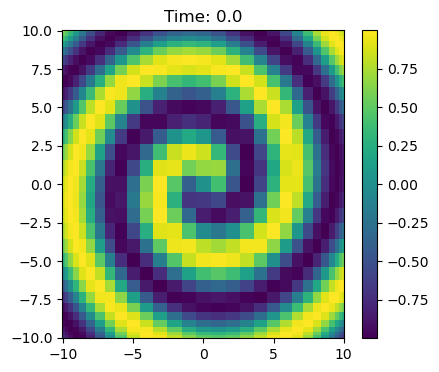

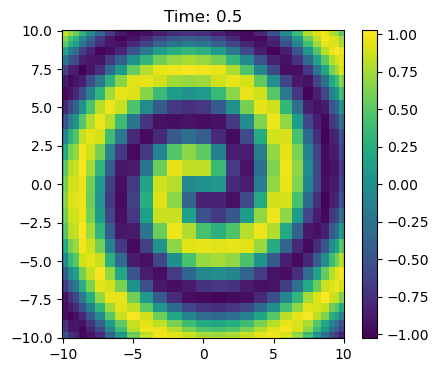

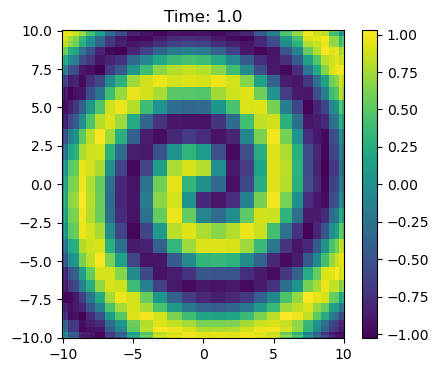

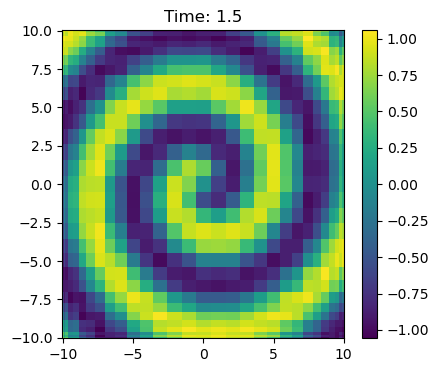

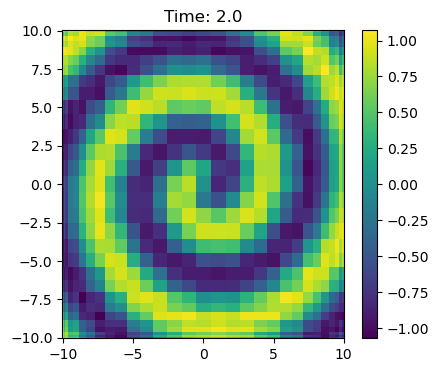

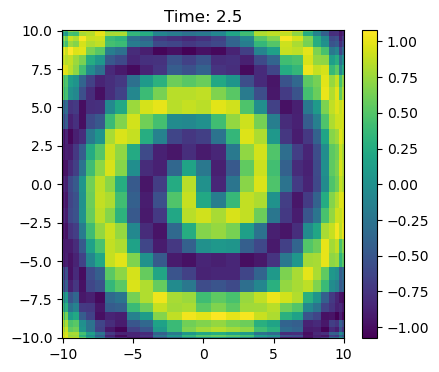

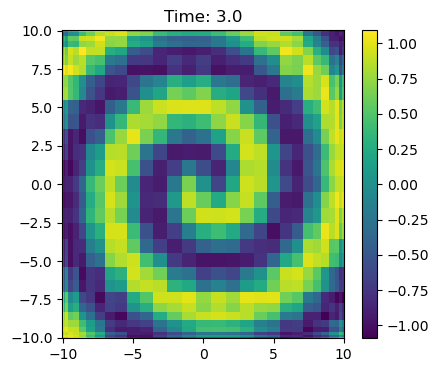

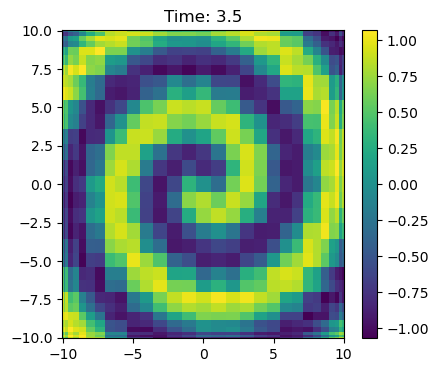

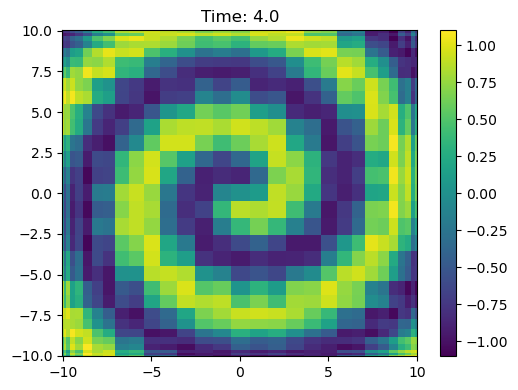

In [39]:
solcf = cheby(u0, v0, tspan, n, L)
print(solcf.shape)
print(solcf)

A2 = solcf

for j, t in enumerate(tspan):
    U = solcf[:N2, j]  
    V = solcf[N2:, j] 

    # V_real = solcf[2*N2:3*N2, j] 
    # V_imag = solcf[3*N2:, j] 
    
    # U_ft = U_real + U_imag
    # V_ft = V_real + 1j * V_imag
  
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.pcolor(x, y, U.reshape(nx +1,ny+1), shading='auto')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
# plt.show()

In [ ]:
## for two arms take m = 2

## for a chaos solution set b= 2.5